In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import models
from torchvision.ops import nms, RoIPool

In [2]:
from src import display
from src import data_transformer as dt
from src.evaluation import jaccard, non_max_suppression, PredBoundingBox, MAP
from src.augmentations import RandomHorizontalFlip, RandomContrast

In [3]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
IMG_PATH = "./data/VOCdevkit/VOC2012/JPEGImages/"
train_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_train.json"
val_json_path = "./data/VOCdevkit/VOC2012/cocoformatJson/voc_2012_val.json"

In [5]:
target_size = 224

seed = 42
device = "cuda"

In [6]:
data_list = []
id_cat, temp_list = dt.load_pascal(train_json_path)
data_list += temp_list
_, temp_list = dt.load_pascal(val_json_path)
data_list += temp_list

random.seed(seed)
random.shuffle(data_list)

In [7]:
data_list = dt.rescale_bounding_boxes(data_list, target_size)
data_list = dt.convert_to_center(data_list)

In [8]:
example = data_list[0]
example

ImageEntry(filename='2009_004619.jpg', width=500, height=333, classnames=['train', 'person', 'person'], class_id=[18, 14, 14], bounding_boxes=[[112.0, 92.5, 224, 185], [80.0, 158.0, 26, 120], [167.0, 83.5, 26, 81]])

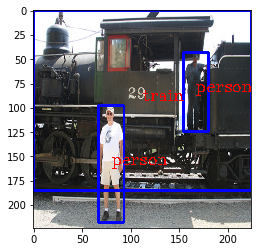

In [9]:
img_str = IMG_PATH + example.filename
img = display.read_img(img_str, target_size)

img = display.draw_boxes(img, example.bounding_boxes)
img = display.draw_text(img, example.classnames, example.bounding_boxes)
plt.imshow(img)
plt.show()

In [10]:
class PascalData(Dataset):
    def __init__(self, data_list_, target_size_=target_size, path_=IMG_PATH, p=0.5, train_mode=False):
        self.target_size = target_size_
        self.path = path_
        self.data_list = data_list_
        self.p = p

        self.mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
        self.std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

        self.train_mode = train_mode
        self.flip = RandomHorizontalFlip(p)
        self.contrast = RandomContrast(p)

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]

        img_str = self.path + item.filename
        img = display.read_img(img_str, self.target_size)
        img = img / 255.0

        gt = np.vstack(item.bounding_boxes)

        if self.train_mode:
            img = self.contrast(img)
            img, gt = self.flip(img, gt)

        img = img.transpose((2, 0, 1))
        img = (img - self.mean) / self.std
        img = torch.from_numpy(img).float().to(device)

        #gt = gt / target_size
        gt = torch.from_numpy(gt).float() / self.target_size
        gt = gt[None, :, :].to(device)

        c = np.array(item.class_id) + 1
        c = torch.from_numpy(np.array(item.class_id)) + 1
        c = c[None, :].to(device)

        return (img, gt, c)

def collate_fn(batch):
    """
    Writing custom collector function since the Dataset class returns both tensors and lists.
    """

    x = [b[0] for b in batch]
    x = torch.stack(x, dim=0)
    gt = [b[1] for b in batch]
    c = [b[2] for b in batch]
    return (x, gt, c)

In [11]:
batch_size = 128
train_size = 0.9

split_idx = int(train_size * len(data_list))

train_dataset = PascalData(data_list[0:split_idx], train_mode=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

val_dataset = PascalData(data_list[split_idx:])
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [12]:
def generator_anchors(img_size, sub_sample=16, ratios=[0.5, 1, 2], anchor_scales=[8, 16, 32]):
    # Subsample-factor: how much have have the feature-map decreased from input to last layer
    # in the backbone. I.e. if input image is 224 and the output from the backbone is 7,
    # sub-sample factor is 32.

    feature_size = img_size // sub_sample
    center_x_array = np.arange(sub_sample, (feature_size + 1) * sub_sample, sub_sample)
    center_y_array = np.arange(sub_sample, (feature_size + 1) * sub_sample, sub_sample)

    num_combinations = len(ratios) * len(anchor_scales)    
    anchors = np.zeros((feature_size * feature_size * num_combinations, 4))

    index = 0
    for x in range(len(center_x_array)):
        for y in range(len(center_y_array)):
            ctr_x = center_x_array[x]
            ctr_y = center_y_array[y]

            for i in range(len(ratios)):
                for j in range(len(anchor_scales)):
                    h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
                    w = sub_sample * anchor_scales[j] * np.sqrt(1.0 / ratios[i])
                    anchors[index, 0] = ctr_x - w / 2.0
                    anchors[index, 1] = ctr_y - h / 2.0
                    anchors[index, 2] = ctr_x + w / 2.0
                    anchors[index, 3] = ctr_y + h / 2.0
                    index += 1

    anchors  = torch.from_numpy(anchors).float()
    return anchors


def loc2bbox(anchors, locs):
    # Converting anchors and predicted location deltas to "actual" bounding-boxes.
    w = anchors[:, 2] - anchors[:, 0]
    h = anchors[:, 3] - anchors[:, 1]
    ctr_x = anchors[:, 0] + 0.5 * w
    ctr_y = anchors[:, 1] + 0.5 * h
    
    dx = locs[:, 0]
    dy = locs[:, 1]
    dw = locs[:, 2]
    dh = locs[:, 3]

    ctr_y = dy * h + ctr_y
    ctr_x = dx * w + ctr_x
    h = torch.exp(dh) * h
    w = torch.exp(dw) * w

    bbox = torch.zeros_like(loc)
    bbox[:, 0] = ctr_x - 0.5 * w
    bbox[:, 1] = ctr_y - 0.5 * h
    bbox[:, 2] = ctr_x + 0.5 * w
    bbox[:, 3] = ctr_y + 0.5 * h
    return bbox

In [13]:
class ProposalLayer(nn.Module):
    def __init__(self, img_size, nms_thresh=0.7, n_train_pre_nms=1000, n_train_post_nms=200,
                 n_test_pre_nms=600, n_test_post_nms=30, min_size=16):
        
        super().__init__()
        self.img_size = img_size
        self.nms_threshold = nms_thresh
        self.n_train_pre_nms = n_train_pre_nms
        self.n_train_post_nms = n_train_post_nms
        self.n_test_pre_nms = n_test_pre_nms
        self.n_test_post_nms = n_test_post_nms
        self.min_size = min_size

    def forward(self, locs, scores, anchors):
        if self.training:
            n_pre_nms = self.n_train_pre_nms
            n_post_nms = self.n_train_post_nms
        else:
            n_pre_nms = self.n_test_pre_nms
            n_post_nms = self.n_test_post_nms

        roi = loc2bbox(anchors, locs)
        roi = torch.clamp(roi, 0, self.img_size)

        # Remove predicted boxes with either height or width < threshold.
        widths = roi[:, 2] - roi[:, 0]
        heights = roi[:, 3] - roi[:, 1]
        keep = torch.where((heights >= self.min_size) & (widths >= self.min_size))[0]
        
        roi = roi[keep, :]
        scores = scores[keep]

        # Sort all (proposal, score) pairs by score from highest to lowest and the the n_pre_nms highest.        
        indicies = torch.argsort(scores, descending=True)        
        indicies = indicies[:n_pre_nms]
        roi = roi[indicies, :]
        scores = scores[indicies]
        
        keep = nms(roi, scores, self.nms_threshold)
        keep = keep[:n_post_nms]
        roi = roi[keep]
        return roi

In [14]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, img_size, in_channels=512, mid_channels=512, ratios=[0.5, 1, 2],
                 anchor_scales=[8, 16, 32], sub_sample=32):
        super().__init__()

        # Note: all images in the forward pass need to be of shape 3 x img_size x img_size
        self.img_size = img_size
        self.anchors = generator_anchors(img_size, sub_sample, anchor_scales=anchor_scales, ratios=ratios)                        
        self.num_base_anchors = len(ratios) * len(anchor_scales)

        self.proposal_layer = ProposalLayer(img_size)

        self.conv = nn.Conv2d(in_channels, mid_channels, kernel_size=3, stride=1, padding=1)
        self.score = nn.Conv2d(mid_channels, 2 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)
        self.loc = nn.Conv2d(mid_channels, 4 * self.num_base_anchors, kernel_size=1, stride=1, padding=0)

    def forward(self, x):        
        n, _, height, width = x.shape        
        h = F.relu(self.conv(x))
        
        rpn_locs = self.loc(h)
        rpn_locs = rpn_locs.permute(0, 2, 3, 1).contiguous().view(n, -1, 4)
        
        rpn_scores = self.score(h)
        rpn_scores = rpn_scores.permute(0, 2, 3, 1).contiguous()
                
        rpn_softmax_scores = F.softmax(rpn_scores.view(n, height, width, self.num_base_anchors, 2), dim=4)

        rpn_fg_scores = rpn_softmax_scores[:, :, :, :, 1].contiguous()
        rpn_fg_scores = rpn_fg_scores.view(n, -1)
        rpn_scores = rpn_scores.view(n, -1, 2)
        
        rois = []
        roi_indices = []
        for i in range(n):
            roi = self.proposal_layer(rpn_locs[i], rpn_fg_scores[i], self.anchors)
            batch_index = i * torch.ones((len(roi),)).int()
            rois.append(roi)
            roi_indices.append(batch_index)

        rois = torch.cat(rois, dim=0)
        roi_indices = torch.cat(roi_indices, dim=0)
        return rpn_locs, rpn_scores, rois, roi_indices, self.anchors

In [15]:
class RoIHead(nn.Module):
    def __init__(self, num_classes, output_size):
        super().__init__()
        
        num_hidden = 256
        
        self.linear = nn.Linear(output_size * output_size * 3, num_hidden)
        self.cls_loc = nn.Linear(num_hidden, 4 * num_classes)
        self.score = nn.Linear(num_hidden, num_classes)
        self.roi_pool = RoIPool(output_size, 1.0)

    def forward(self, x, rois, roi_indices):
        indicies_and_rois = torch.cat([
            roi_indices.float().unsqueeze(-1),
            rois
        ], dim=1)
        
        pool_vals = self.roi_pool(x, indicies_and_rois)
        pool_vals = pool_vals.view(pool_vals.size(0), -1)
        
        h = F.relu(self.linear(pool_vals))
        roi_cls_locs = self.cls_loc(h)
        roi_scores = self.score(h)
        return roi_cls_locs, roi_scores

In [16]:
class FasterRCNN(nn.Module):
    def __init__(self, img_size, num_classes, output_size=7):
        super().__init__()

        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-2]
        self.backbone = nn.Sequential(*pretrained_model)
        self.region_proposal_network = RegionProposalNetwork(img_size, sub_sample=32)
        self.roi_head = RoIHead(num_classes, output_size)

    def forward(self, x):
        feature_map = self.backbone(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchors = self.region_proposal_network(feature_map)        
        roi_cls_locs, roi_scores = self.roi_head(x, rois, roi_indices)        
        return roi_cls_locs, roi_scores, rois, roi_indices

In [17]:
dummy_data = torch.zeros((4, 3, 224, 224)).float()

In [18]:
model = FasterRCNN(224)

In [19]:
_ = model(dummy_data)